<a href="https://colab.research.google.com/github/PaoloSani/SASP-Project/blob/First-attempt/simplified_reverberation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reverberant Speech Enhancement



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import IPython.display as ipd
import scipy.signal 

In [85]:
# SPEECH SIGNAL

random_sequence = np.random.randint(20,94000,10) # numeri a caso 
print(random_sequence)
N = 96000
speech_signal = np.zeros((N,))

for i in random_sequence:
  speech_signal[i:i+2000] = np.random.normal(0, 0.2, 2000)

[ 3316 77100 73016  7413 66508 86173  9557 32240 47678 82742]


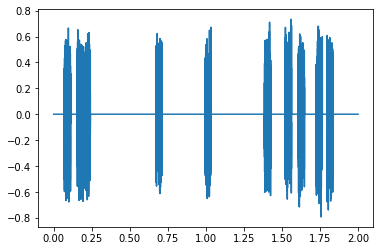

In [86]:
Fs = 48000
time = np.arange(0,N)/Fs
plt.plot(time,speech_signal);
ipd.display(ipd.Audio(speech_signal, rate=Fs))

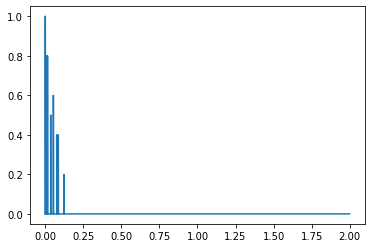

In [88]:
# Impulse response
IR = np.zeros((N,))
IR[1] = 1
IR[200] = 0.8
IR[700] = 0.8
IR[1700] = 0.5
IR[2550] = 0.6
IR[3600] = 0.4
IR[4100] = 0.4
IR[5850] = 0.2
plt.plot(time,IR);

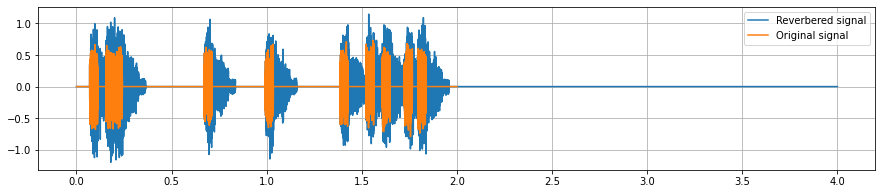

In [89]:
# REVERBERATION
reverbered_signal = np.convolve(speech_signal, IR)

L = len(reverbered_signal)

time = np.arange(0,L)/Fs
plt.figure(1,(15,3))

plt.plot(time, reverbered_signal);
plt.plot(time[0:len(speech_signal)],speech_signal)
plt.grid('minor')
plt.legend(["Reverbered signal","Original signal"]);

ipd.display(ipd.Audio(reverbered_signal, rate=Fs))

# ANALYSIS

Segment 1 contains 14089 samples (0.29352083333333334 seconds)
Segment 2 contains 7848 samples (0.1635 seconds)
Segment 3 contains 7848 samples (0.1635 seconds)
Segment 4 contains 27513 samples (0.5731666666666667 seconds)
[(3317, 17406), (32241, 40089), (47679, 55527), (66509, 94021)]


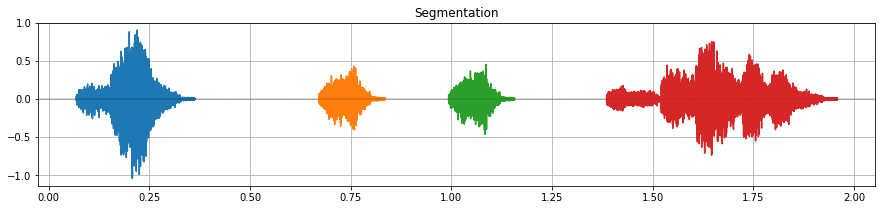

In [90]:
# SEGMENTATION

nonzero_idx = np.nonzero(reverbered_signal)[0]
segments = list()
segment = np.zeros((L,))

j = 0 ; n = 0 # Number of segments

time_intervals = list()
start = nonzero_idx[0]
for i in range(len(nonzero_idx)-1):
  
  if i >= len(nonzero_idx)-2: # Last segment
    segment[j] = reverbered_signal[nonzero_idx[i]]
    segments.append(segment[0:j])
    j = j+1 ; n = n+1
    stop = nonzero_idx[i]
    time_intervals.append((start,stop))
    print("Segment {} contains {} samples ({} seconds)".format(n,j,(stop - start)/Fs))

  elif nonzero_idx[i+1] - nonzero_idx[i] <= 32:
    segment[j] = reverbered_signal[nonzero_idx[i]]
    j = j + 1
  
  else:
    segments.append(segment[0:j])
    stop = nonzero_idx[i]
    n = n+1
    print("Segment {} contains {} samples ({} seconds)".format(n,j,(stop - start)/Fs))
    segment = np.zeros((L,))
    time_intervals.append((start,stop))
    j = 0
    start = nonzero_idx[i+1]

print(time_intervals)

# PLOT SEGMENTS

cc = np.stack([[0, 0.4470, 0.7410], [0.8500, 0.3250, 0.0980], [0.9290, 0.6940, 0.1250],
               [0.4940, 0.1840, 0.5560], [0.4660, 0.6740, 0.1880], [0.3010, 0.7450, 0.9330],
               [0.6350, 0.0780, 0.1840]])

plt.figure(2,(15,3))
for i,sgm in enumerate(segments):
  tau = len(sgm)/4 # scelto a caso
  window = scipy.signal.windows.exponential(len(sgm),tau=tau,sym='True') # exponential symmetric window
  sgm = window*sgm
  start = time_intervals[i][0]
  stop = time_intervals[i][1]
  plt.plot(time[start:stop],sgm)
  plt.grid('minor')
  plt.title("Segmentation")
  plt.axhline(y=0,c='k',linestyle='--',lw=0.1)

We have 4 segments


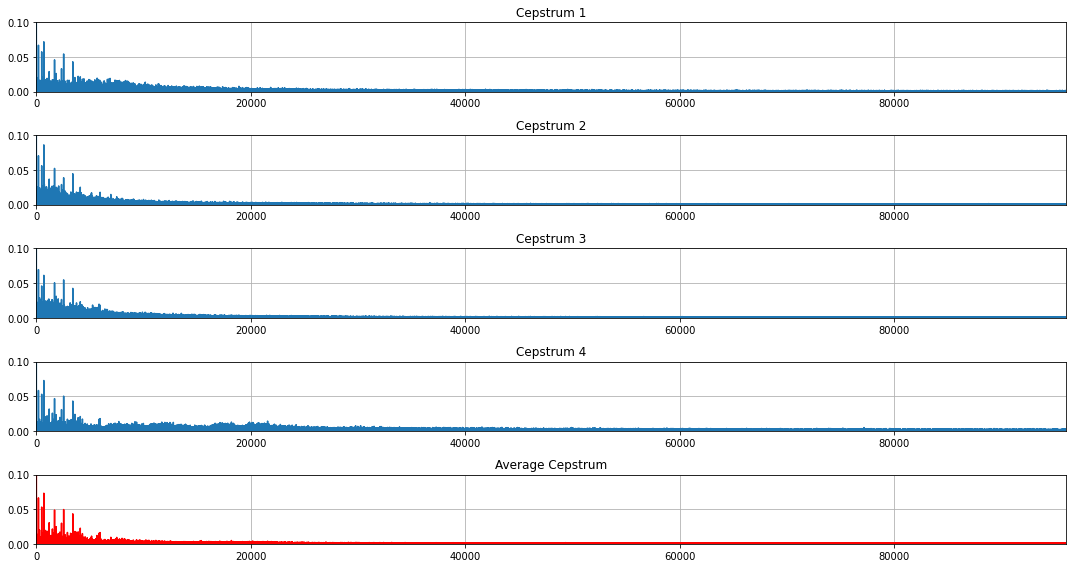

In [92]:
# CEPSTRUM COMPUTATION

print("We have {} segments".format(n))
cepstra = np.zeros((n,L),dtype='complex')

plt.figure(3,(15,n*2))
for i, sgm in enumerate(segments):
  spectrum = np.fft.fft(segments[i],L) # FFT della stessa lunghezza del segnale iniziale, ci servirà dopo
  cepstra[i] = np.fft.ifft(np.log10(spectrum))
  plt.subplot(n+1,1,i+1)
  plt.plot(abs(cepstra[i]))
  plt.grid('minor')
  plt.axis([0,L/2,0,0.1])
  plt.title("Cepstrum {}".format(i+1))
  plt.tight_layout()

avg_cepstrum = np.mean(cepstra,0)
plt.subplot(n+1,1,n+1)
plt.plot(abs(avg_cepstrum),'r')
plt.grid('minor')
plt.axis([0,L/2,0,0.1])
plt.title("Average Cepstrum")
plt.tight_layout()

# DEREVERBERATION

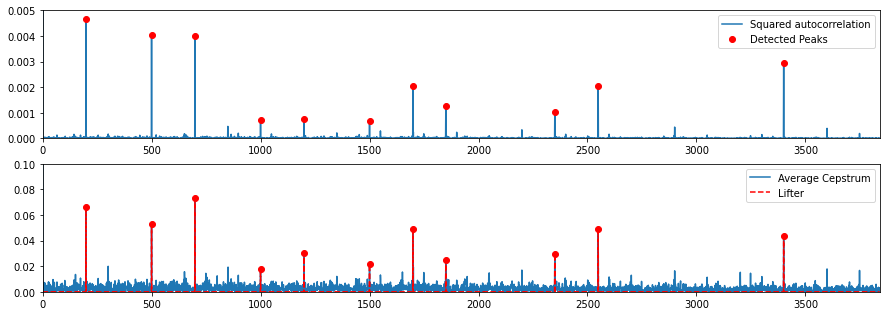

In [115]:
# PEAKS DETECTION
quefrency = np.arange(0,len(avg_cepstrum))
autocorr_avgcepstrum = scipy.signal.correlate(avg_cepstrum,avg_cepstrum)
autocorr_avgcepstrum = autocorr_avgcepstrum[L-1:-1]
autocorr_squared = np.power(autocorr_avgcepstrum,2)
thresh = np.mean(abs(autocorr_avgcepstrum))
peaks,_ = scipy.signal.find_peaks(abs(autocorr_squared),height=thresh)

# la stima dei peaks sulla base del quadrato dell'autocorrelazione porta a risultati top
# ma è fatto tutto abbastanza a cazzo


# LIFTER DEFINITION
lifter = np.zeros((L,),dtype='complex')
lifter[peaks] = avg_cepstrum[peaks]

plt.figure(4,(15,8))

plt.subplot(3,1,1)
plt.plot(abs(autocorr_squared))
plt.plot(quefrency[peaks],abs(autocorr_squared[peaks]),'ro');
plt.axis([0,L/50,0,0.005])
plt.legend(["Squared autocorrelation","Detected Peaks"])

plt.subplot(3,1,2)
plt.plot(quefrency,abs(avg_cepstrum));
plt.plot(quefrency, abs(lifter),'r--');
plt.plot(quefrency[peaks],abs(avg_cepstrum[peaks]),'ro');
plt.axis([0,L/50,0,0.1]);
plt.legend(["Average Cepstrum","Lifter"])

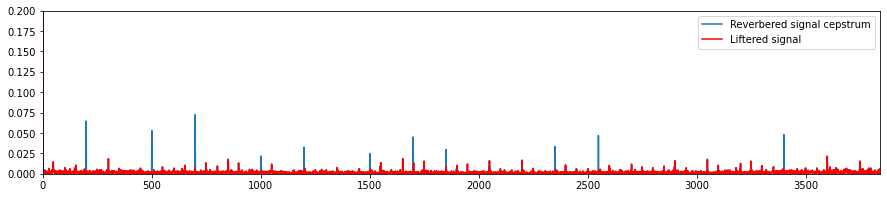

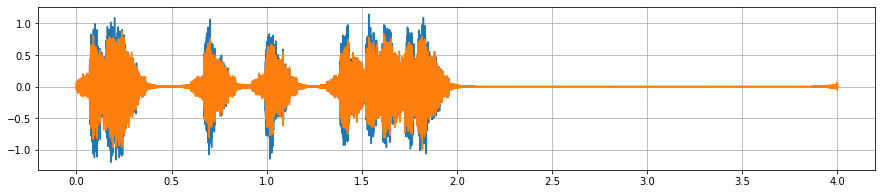

In [117]:
# LIFTERING
reverbered_signal_cepstrum = np.fft.ifft(np.log10(np.fft.fft(reverbered_signal)))
liftered_cepstrum = reverbered_signal_cepstrum - lifter # They must have same length

plt.figure(5,(15,3))
plt.plot(abs(reverbered_signal_cepstrum));
plt.plot(abs(liftered_cepstrum),'r');
plt.legend(["Reverbered signal cepstrum","Liftered signal"]);
plt.axis([0,L/50,0,0.2]);

# BACK TO TIME DOMAIN
dereverbered_signal = np.fft.ifft(np.power(10,np.fft.fft(liftered_cepstrum)))

plt.figure(6,(15,3))
plt.plot(time,reverbered_signal)
plt.plot(time,np.real(dereverbered_signal))
plt.grid('minor')

ipd.display(ipd.Audio(np.real(dereverbered_signal), rate=Fs))